# Portfolio 2

In [1]:
import os
path = '/work/SofieNørboMosegaard#5741/AdvCogNeuro/'
os.chdir(path)
!./activate.sh

Installed kernelspec virt_env in /home/ucloud/.local/share/jupyter/kernels/virt_env
Done! Remember changing the kernel in Jupyter.


In [1]:
import os
import sys
import nibabel as nib
import numpy as np
import pandas as pd
import pickle
import inspect
from datetime import datetime
from collections import Counter
from scipy.stats import norm

from nilearn import image, plotting
from nilearn.glm.first_level import FirstLevelModel, first_level_from_bids
from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm.contrasts import compute_contrast
from nilearn.plotting import plot_contrast_matrix, plot_stat_map
from nilearn.reporting import get_clusters_table
from nilearn.image import mean_img, load_img, concat_imgs, iter_img, index_img

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from nilearn.glm.first_level import make_first_level_design_matrix, FirstLevelModel
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

US1_J2KR.dcm:   0%|          | 38.0/154k [00:00<01:47, 1.44kB/s]
MR-SIEMENS-DICOM-WithOverlays.dcm:   0%|          | 125/511k [00:00<02:57, 2.88kB/s]
OBXXXX1A.dcm:   0%|          | 119/486k [00:00<03:00, 2.69kB/s]
US1_UNCR.dcm:   0%|          | 226/923k [00:00<03:53, 3.94kB/s]
color3d_jpeg_baseline.dcm:   0%|          | 1.50k/6.14M [00:00<06:14, 16.4kB/s]


## BIDS dataset first and second level analysis

In [2]:
# import some functionality
from datetime import datetime

now = datetime.now()
print('Starting cell:',now.strftime("%H:%M:%S"))
import os
import pip
import matplotlib.pyplot as plt

%matplotlib inline

now = datetime.now()
print('Finishing cell:',now.strftime("%H:%M:%S"))

Starting cell: 08:38:08
Finishing cell: 08:38:08


## Fetch faceWord BIDS dataset
The Iowa dataset is located in the `fMRI_data/BID_2024E` folder.

In [3]:
def list_files(startpath):
    """ Simple function to show directory tree. 
    From: https://stackoverflow.com/questions/9727673/list-directory-tree-structure-in-python. """
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
        for f in sorted(files):
            print('{}{}'.format(subindent, f))
            
data_dir = '/work/fMRI_data/BIDS_2024E/' 
derivatives_dir =  '/work/fMRI_data/BIDS_2024E/derivatives/'   

## Obtain automatically FirstLevelModel objects and fit arguments

In [4]:
#BIDS directory
data_dir='/work/fMRI_data/BIDS_2024E/'

# BIDS derivatives (contains preprocessed data)
derivatives_dir='/work/fMRI_data/BIDS_2024E/derivatives' 

# Name for experiment in the BIDS directory
task_label = 'boldiowa'

# Label for data that are spatially aligned to the MNI152 template (i.e. spatially normalised)
space_label ='MNI152NLin2009cAsym'

#Run the function that can gather all the needed info from a BIDS folder
models, models_run_imgs, models_events, models_confounds = \
    first_level_from_bids(
        data_dir, task_label, derivatives_folder=derivatives_dir, n_jobs=-2, verbose=1,
        img_filters=[('desc', 'preproc')])

#Print the data from the first participant as sanity check
print(models_run_imgs[0])

now = datetime.now()
print('Finishing cell:',now.strftime("%H:%M:%S"))

/work/SofieNørboMosegaard#5741/AdvCogNeuro/virt_env/lib/python3.12/site-packages/nilearn/glm/first_level/first_level.py:1398: UserWarning: 'slice_time_ref' provided (0.0) is different from the value found in the BIDS dataset (0.462).
Note this may lead to the wrong model specification.
  warn(
/work/SofieNørboMosegaard#5741/AdvCogNeuro/virt_env/lib/python3.12/site-packages/nilearn/glm/first_level/first_level.py:1454: UserWarning: The filter ('desc', 'preproc') will be skipped. 'desc' is not among the supported filters. Allowed filters include: ['sub', 'ses', 'task', 'acq', 'ce', 'rec', 'dir', 'run', 'echo', 'part']
  events = _get_events_files(
/work/SofieNørboMosegaard#5741/AdvCogNeuro/virt_env/lib/python3.12/site-packages/nilearn/glm/first_level/first_level.py:1467: UserWarning: The filter ('desc', 'preproc') will be skipped. 'desc' is not among the supported filters. Allowed filters include: ['sub', 'ses', 'task', 'acq', 'ce', 'rec', 'dir', 'run', 'echo', 'part']
  confounds = _get_

Found the following 4 preprocessed BOLD files
 for subject 0139
 for filter: [('task', 'boldiowa'), ('desc', 'preproc')]:
 ['/work/fMRI_data/BIDS_2024E/derivatives/sub-0139/ses-001/func/sub-0139_ses-001_task-boldiowa_run-1_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', '/work/fMRI_data/BIDS_2024E/derivatives/sub-0139/ses-001/func/sub-0139_ses-001_task-boldiowa_run-2_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', '/work/fMRI_data/BIDS_2024E/derivatives/sub-0139/ses-001/func/sub-0139_ses-001_task-boldiowa_run-3_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', '/work/fMRI_data/BIDS_2024E/derivatives/sub-0139/ses-001/func/sub-0139_ses-001_task-boldiowa_run-4_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz']

Found the following 4 events files
 for subject 0139
 for filter: [('task', 'boldiowa')]:
 ['/work/fMRI_data/BIDS_2024E/sub-0139/ses-001/func/sub-0139_ses-001_task-boldiowa_run-1_echo-1_events.tsv', '/work/fMRI_data/BIDS_2024E/sub-0139/ses

/work/SofieNørboMosegaard#5741/AdvCogNeuro/virt_env/lib/python3.12/site-packages/nilearn/glm/first_level/first_level.py:1454: UserWarning: The filter ('desc', 'preproc') will be skipped. 'desc' is not among the supported filters. Allowed filters include: ['sub', 'ses', 'task', 'acq', 'ce', 'rec', 'dir', 'run', 'echo', 'part']
  events = _get_events_files(
/work/SofieNørboMosegaard#5741/AdvCogNeuro/virt_env/lib/python3.12/site-packages/nilearn/glm/first_level/first_level.py:1467: UserWarning: The filter ('desc', 'preproc') will be skipped. 'desc' is not among the supported filters. Allowed filters include: ['sub', 'ses', 'task', 'acq', 'ce', 'rec', 'dir', 'run', 'echo', 'part']
  confounds = _get_confounds(


Found the following 4 preprocessed BOLD files
 for subject 0142
 for filter: [('task', 'boldiowa'), ('desc', 'preproc')]:
 ['/work/fMRI_data/BIDS_2024E/derivatives/sub-0142/ses-001/func/sub-0142_ses-001_task-boldiowa_run-1_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', '/work/fMRI_data/BIDS_2024E/derivatives/sub-0142/ses-001/func/sub-0142_ses-001_task-boldiowa_run-2_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', '/work/fMRI_data/BIDS_2024E/derivatives/sub-0142/ses-001/func/sub-0142_ses-001_task-boldiowa_run-3_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', '/work/fMRI_data/BIDS_2024E/derivatives/sub-0142/ses-001/func/sub-0142_ses-001_task-boldiowa_run-4_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz']

Found the following 4 events files
 for subject 0142
 for filter: [('task', 'boldiowa')]:
 ['/work/fMRI_data/BIDS_2024E/sub-0142/ses-001/func/sub-0142_ses-001_task-boldiowa_run-1_echo-1_events.tsv', '/work/fMRI_data/BIDS_2024E/sub-0142/ses

/work/SofieNørboMosegaard#5741/AdvCogNeuro/virt_env/lib/python3.12/site-packages/nilearn/glm/first_level/first_level.py:1454: UserWarning: The filter ('desc', 'preproc') will be skipped. 'desc' is not among the supported filters. Allowed filters include: ['sub', 'ses', 'task', 'acq', 'ce', 'rec', 'dir', 'run', 'echo', 'part']
  events = _get_events_files(
/work/SofieNørboMosegaard#5741/AdvCogNeuro/virt_env/lib/python3.12/site-packages/nilearn/glm/first_level/first_level.py:1467: UserWarning: The filter ('desc', 'preproc') will be skipped. 'desc' is not among the supported filters. Allowed filters include: ['sub', 'ses', 'task', 'acq', 'ce', 'rec', 'dir', 'run', 'echo', 'part']
  confounds = _get_confounds(


Found the following 4 preprocessed BOLD files
 for subject 0141
 for filter: [('task', 'boldiowa'), ('desc', 'preproc')]:
 ['/work/fMRI_data/BIDS_2024E/derivatives/sub-0141/ses-001/func/sub-0141_ses-001_task-boldiowa_run-1_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', '/work/fMRI_data/BIDS_2024E/derivatives/sub-0141/ses-001/func/sub-0141_ses-001_task-boldiowa_run-2_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', '/work/fMRI_data/BIDS_2024E/derivatives/sub-0141/ses-001/func/sub-0141_ses-001_task-boldiowa_run-3_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', '/work/fMRI_data/BIDS_2024E/derivatives/sub-0141/ses-001/func/sub-0141_ses-001_task-boldiowa_run-4_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz']

Found the following 4 events files
 for subject 0141
 for filter: [('task', 'boldiowa')]:
 ['/work/fMRI_data/BIDS_2024E/sub-0141/ses-001/func/sub-0141_ses-001_task-boldiowa_run-1_echo-1_events.tsv', '/work/fMRI_data/BIDS_2024E/sub-0141/ses

/work/SofieNørboMosegaard#5741/AdvCogNeuro/virt_env/lib/python3.12/site-packages/nilearn/glm/first_level/first_level.py:1454: UserWarning: The filter ('desc', 'preproc') will be skipped. 'desc' is not among the supported filters. Allowed filters include: ['sub', 'ses', 'task', 'acq', 'ce', 'rec', 'dir', 'run', 'echo', 'part']
  events = _get_events_files(
/work/SofieNørboMosegaard#5741/AdvCogNeuro/virt_env/lib/python3.12/site-packages/nilearn/glm/first_level/first_level.py:1467: UserWarning: The filter ('desc', 'preproc') will be skipped. 'desc' is not among the supported filters. Allowed filters include: ['sub', 'ses', 'task', 'acq', 'ce', 'rec', 'dir', 'run', 'echo', 'part']
  confounds = _get_confounds(


Found the following 4 preprocessed BOLD files
 for subject 0136
 for filter: [('task', 'boldiowa'), ('desc', 'preproc')]:
 ['/work/fMRI_data/BIDS_2024E/derivatives/sub-0136/ses-001/func/sub-0136_ses-001_task-boldiowa_run-1_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', '/work/fMRI_data/BIDS_2024E/derivatives/sub-0136/ses-001/func/sub-0136_ses-001_task-boldiowa_run-2_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', '/work/fMRI_data/BIDS_2024E/derivatives/sub-0136/ses-001/func/sub-0136_ses-001_task-boldiowa_run-3_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', '/work/fMRI_data/BIDS_2024E/derivatives/sub-0136/ses-001/func/sub-0136_ses-001_task-boldiowa_run-4_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz']

Found the following 4 events files
 for subject 0136
 for filter: [('task', 'boldiowa')]:
 ['/work/fMRI_data/BIDS_2024E/sub-0136/ses-001/func/sub-0136_ses-001_task-boldiowa_run-1_echo-1_events.tsv', '/work/fMRI_data/BIDS_2024E/sub-0136/ses

/work/SofieNørboMosegaard#5741/AdvCogNeuro/virt_env/lib/python3.12/site-packages/nilearn/glm/first_level/first_level.py:1454: UserWarning: The filter ('desc', 'preproc') will be skipped. 'desc' is not among the supported filters. Allowed filters include: ['sub', 'ses', 'task', 'acq', 'ce', 'rec', 'dir', 'run', 'echo', 'part']
  events = _get_events_files(
/work/SofieNørboMosegaard#5741/AdvCogNeuro/virt_env/lib/python3.12/site-packages/nilearn/glm/first_level/first_level.py:1467: UserWarning: The filter ('desc', 'preproc') will be skipped. 'desc' is not among the supported filters. Allowed filters include: ['sub', 'ses', 'task', 'acq', 'ce', 'rec', 'dir', 'run', 'echo', 'part']
  confounds = _get_confounds(


Found the following 4 preprocessed BOLD files
 for subject 0140
 for filter: [('task', 'boldiowa'), ('desc', 'preproc')]:
 ['/work/fMRI_data/BIDS_2024E/derivatives/sub-0140/ses-001/func/sub-0140_ses-001_task-boldiowa_run-1_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', '/work/fMRI_data/BIDS_2024E/derivatives/sub-0140/ses-001/func/sub-0140_ses-001_task-boldiowa_run-2_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', '/work/fMRI_data/BIDS_2024E/derivatives/sub-0140/ses-001/func/sub-0140_ses-001_task-boldiowa_run-3_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', '/work/fMRI_data/BIDS_2024E/derivatives/sub-0140/ses-001/func/sub-0140_ses-001_task-boldiowa_run-4_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz']

Found the following 4 events files
 for subject 0140
 for filter: [('task', 'boldiowa')]:
 ['/work/fMRI_data/BIDS_2024E/sub-0140/ses-001/func/sub-0140_ses-001_task-boldiowa_run-1_echo-1_events.tsv', '/work/fMRI_data/BIDS_2024E/sub-0140/ses

/work/SofieNørboMosegaard#5741/AdvCogNeuro/virt_env/lib/python3.12/site-packages/nilearn/glm/first_level/first_level.py:1454: UserWarning: The filter ('desc', 'preproc') will be skipped. 'desc' is not among the supported filters. Allowed filters include: ['sub', 'ses', 'task', 'acq', 'ce', 'rec', 'dir', 'run', 'echo', 'part']
  events = _get_events_files(
/work/SofieNørboMosegaard#5741/AdvCogNeuro/virt_env/lib/python3.12/site-packages/nilearn/glm/first_level/first_level.py:1467: UserWarning: The filter ('desc', 'preproc') will be skipped. 'desc' is not among the supported filters. Allowed filters include: ['sub', 'ses', 'task', 'acq', 'ce', 'rec', 'dir', 'run', 'echo', 'part']
  confounds = _get_confounds(


['/work/fMRI_data/BIDS_2024E/derivatives/sub-0139/ses-001/func/sub-0139_ses-001_task-boldiowa_run-1_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', '/work/fMRI_data/BIDS_2024E/derivatives/sub-0139/ses-001/func/sub-0139_ses-001_task-boldiowa_run-2_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', '/work/fMRI_data/BIDS_2024E/derivatives/sub-0139/ses-001/func/sub-0139_ses-001_task-boldiowa_run-3_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', '/work/fMRI_data/BIDS_2024E/derivatives/sub-0139/ses-001/func/sub-0139_ses-001_task-boldiowa_run-4_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz']
Finishing cell: 08:39:22


In [5]:
#What does the `first_level_from_bid` function take as arguments?

#Get the argument from the function
args=inspect.getfullargspec(first_level_from_bids)

#Make a dataframe to display arguments (skip the first two ('dataset_path' and 'task_label') that have no defaults
df = pd.DataFrame(args.defaults,args.args[2:])
print(df)

#Same info can also be obtained by writing first_level_from_bids?

now = datetime.now()
print('Finishing cell:',now.strftime("%H:%M:%S"))

                                        0
space_label                          None
sub_labels                           None
img_filters                          None
t_r                                  None
slice_time_ref                        0.0
hrf_model                          glover
drift_model                        cosine
high_pass                            0.01
drift_order                             1
fir_delays                            [0]
min_onset                             -24
mask_img                             None
target_affine                        None
target_shape                         None
smoothing_fwhm                       None
memory              Memory(location=None)
memory_level                            1
standardize                         False
signal_scaling                          0
noise_model                           ar1
verbose                                 0
n_jobs                                  1
minimize_memory                   

## Quick sanity check on fit arguments

In [6]:
# Get the file names for subj01 functional data

func01=([os.path.basename(run) for run in models_run_imgs[0]])
print(func01)

['sub-0139_ses-001_task-boldiowa_run-1_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', 'sub-0139_ses-001_task-boldiowa_run-2_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', 'sub-0139_ses-001_task-boldiowa_run-3_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', 'sub-0139_ses-001_task-boldiowa_run-4_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz']


In [7]:
# Get the full path
func01_path=([os.path.abspath(run) for run in models_run_imgs[0]])

# Load the image and inspect data size
func_img = image.load_img(func01_path)
print("Shape of functional MRI image: %s" % (func_img.shape,))

Shape of functional MRI image: (78, 92, 78, 2400)


As we see, the data contains 4x600 = 2400 volumes with a 78 x 92 x78 voxel resolution.

In [8]:
print(models[0])

FirstLevelModel(n_jobs=-2, subject_label='0139', t_r=1, verbose=1)


In [9]:
# Print model confounds for first participant, first run
print(models_confounds[0][0].columns)

Index(['global_signal', 'global_signal_derivative1',
       'global_signal_derivative1_power2', 'global_signal_power2', 'csf',
       'csf_derivative1', 'csf_power2', 'csf_derivative1_power2',
       'white_matter', 'white_matter_derivative1',
       ...
       'rot_x_derivative1_power2', 'rot_y', 'rot_y_derivative1',
       'rot_y_derivative1_power2', 'rot_y_power2', 'rot_z',
       'rot_z_derivative1', 'rot_z_power2', 'rot_z_derivative1_power2',
       'motion_outlier00'],
      dtype='object', length=501)


In [10]:

confound_friston24 = ['trans_x','trans_y','trans_z',
                 'rot_x','rot_y','rot_z','trans_x_derivative1','trans_y_derivative1','trans_z_derivative1',
                 'rot_x_derivative1','rot_y_derivative1','rot_z_derivative1','trans_x_power2','trans_y_power2','trans_z_power2',
                 'rot_x_power2','rot_y_power2','rot_z_power2']

confound_friston24_GSR = ['global_signal','global_signal_derivative1','global_signal_power2','global_signal_derivative1_power2','trans_x','trans_y','trans_z',
                 'rot_x','rot_y','rot_z','trans_x_derivative1','trans_y_derivative1','trans_z_derivative1',
                 'rot_x_derivative1','rot_y_derivative1','rot_z_derivative1','trans_x_power2','trans_y_power2','trans_z_power2',
                 'rot_x_power2','rot_y_power2','rot_z_power2']

# Subset confounds with selection
for ii in range(len(models_confounds)):
    confounds1=models_confounds[ii][:].copy()
    for i in range(len(confounds1)):
        confounds2=confounds1[i].copy()
        confounds2=confounds2[confound_friston24_GSR]
        
        #Removing NAs in the first row.
        confounds2.loc[0,:]=confounds2.loc[1,:]
        confounds1[i]=confounds2
    models_confounds[ii][:]=confounds1


#Print new confounds, for first participant, first run
print(models_confounds[0][0].columns)

now = datetime.now()
print('Finishing cell:',now.strftime("%H:%M:%S"))

Index(['global_signal', 'global_signal_derivative1', 'global_signal_power2',
       'global_signal_derivative1_power2', 'trans_x', 'trans_y', 'trans_z',
       'rot_x', 'rot_y', 'rot_z', 'trans_x_derivative1', 'trans_y_derivative1',
       'trans_z_derivative1', 'rot_x_derivative1', 'rot_y_derivative1',
       'rot_z_derivative1', 'trans_x_power2', 'trans_y_power2',
       'trans_z_power2', 'rot_x_power2', 'rot_y_power2', 'rot_z_power2'],
      dtype='object')
Finishing cell: 08:40:49


### Events from the experiment

In [16]:
print(models_events[3][0])

         onset  duration   win  loss   total trial_type  response  n_moves  \
0     0.987821       5.0   NaN   NaN     NaN      decks       1.0      3.0   
1    15.975475       5.0   NaN   NaN     NaN      decks       2.0      2.0   
2    30.976137       5.0   NaN   NaN     NaN      decks       3.0      3.0   
3    45.976909       5.0   NaN   NaN     NaN      decks       4.0      2.0   
4    60.977569       5.0   NaN   NaN     NaN      decks       2.0      1.0   
..         ...       ...   ...   ...     ...        ...       ...      ...   
75  536.531970       2.0  50.0   0.0 -1000.0        win       NaN      NaN   
76  551.532935       2.0  50.0   0.0  -950.0        win       NaN      NaN   
77  566.533414       2.0  50.0   0.0  -900.0        win       NaN      NaN   
78  581.534067       2.0  50.0   0.0  -850.0        win       NaN      NaN   
79  596.534781       2.0  50.0 -50.0  -850.0    neutral       NaN      NaN   

           RT  run   ID      task  
0    3.807259    1  141  bo

In [17]:
# Print model confounds for first participant, first run
print(models_events[0][0].columns)

events_sub= ['onset','duration','trial_type']

# Subset confounds with selection
for ii in range(len(models_events)):
    events1=models_events[ii][:]
    for i in range(len(events1)):
        events2=events1[i]
        events2=events2[events_sub]
        events1[i]=events2
    models_events[ii][:]=events1


# Print new confounds, for first participant, first run
print(models_events[0][0].columns)

now = datetime.now()
print('Finishing cell:',now.strftime("%H:%M:%S"))

Index(['onset', 'duration', 'win', 'loss', 'total', 'trial_type', 'response',
       'n_moves', 'RT', 'run', 'ID', 'task'],
      dtype='object')
Index(['onset', 'duration', 'trial_type'], dtype='object')
Finishing cell: 08:41:43


In [19]:
print(models[3])

FirstLevelModel(n_jobs=-2, subject_label='0141', t_r=1, verbose=1)


In [26]:
print(models_events[3][1]['trial_type'].value_counts())

trial_type
decks      40
win        27
neutral    12
loss        1
Name: count, dtype: int64


## First level (single subject) model estimation

In [ ]:
# Get data and model info for 1st participant
model1 = models[0]
imgs1 = models_run_imgs[0]
events1 = models_events[0]
confounds1 = models_confounds[0]

# Fit the model
model1.fit(imgs1,events1,confounds1)
model1.zmap = model1.compute_contrast('win-neutral')

now = datetime.now()
print('Finishing cell:',now.strftime("%H:%M:%S"))

### Plotting the design matrix

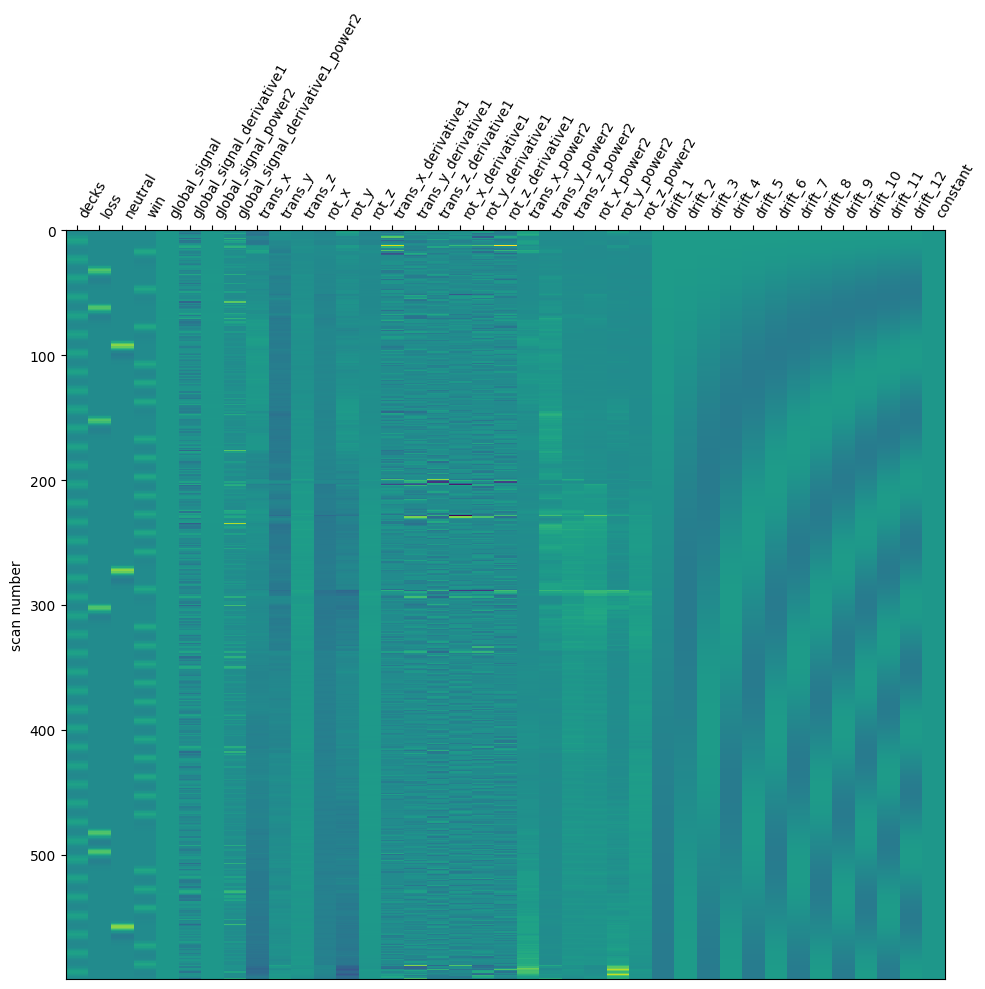

Finishing cell: 09:41:06


In [17]:
# View the design matrix
design_matrix = model1.design_matrices_[0]

#Plot the design matrix
plot_design_matrix(design_matrix)
plt.show()

now = datetime.now()
print('Finishing cell:',now.strftime("%H:%M:%S"))

### Defining contrasts

Finishing cell: 09:41:29


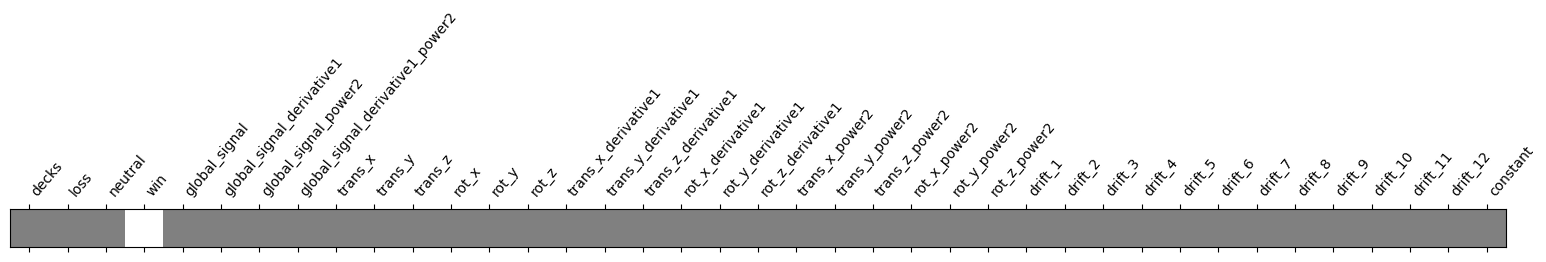

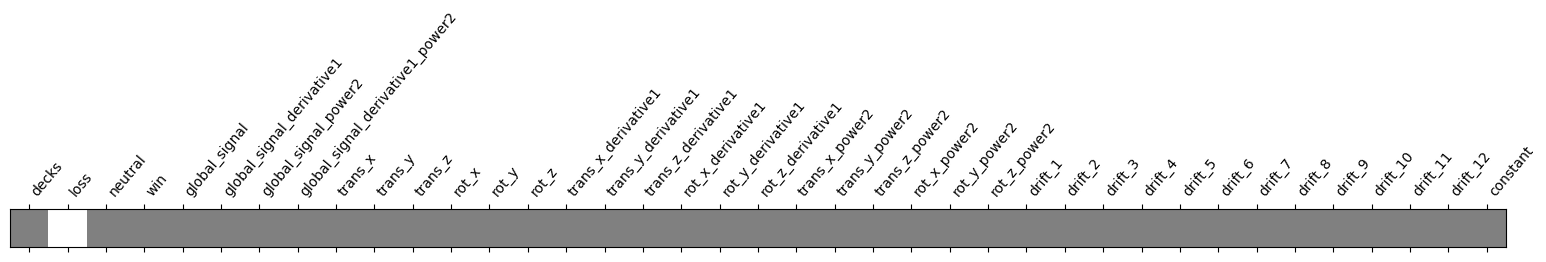

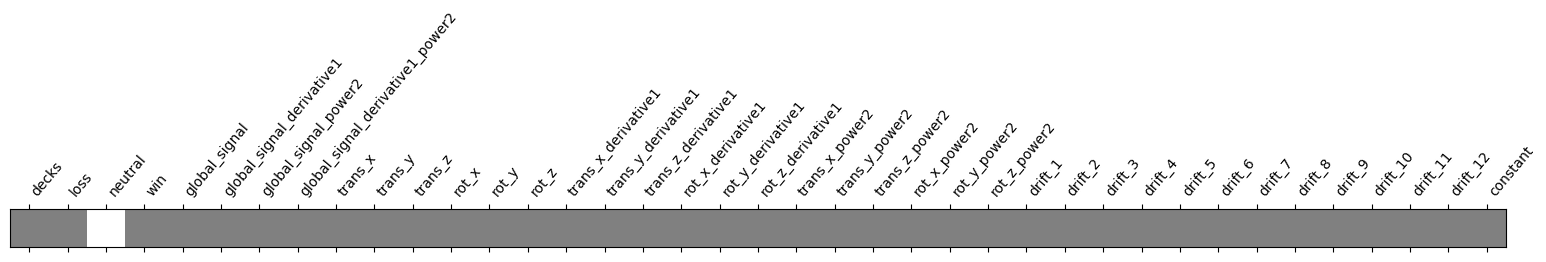

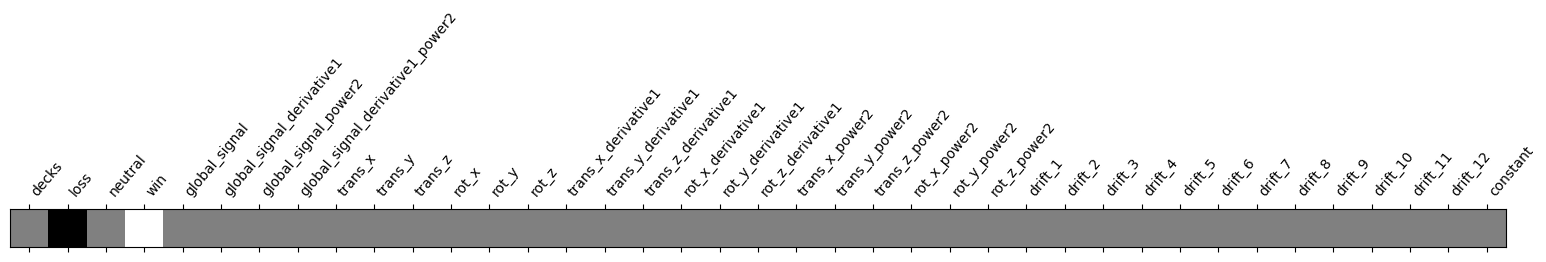

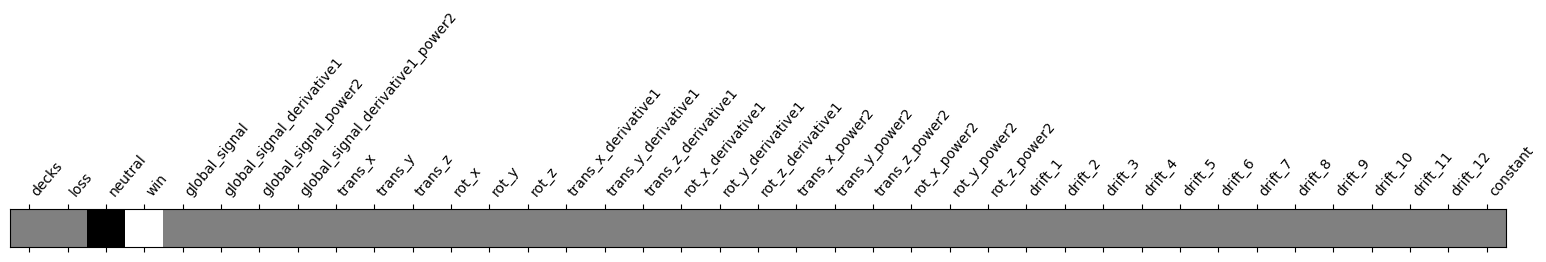

In [18]:
# Define contrasts
contrasts = ['win','loss','neutral', 'win-loss','win-neutral']

# Plot them to see what they look like
for contrast in contrasts:
    plot_contrast_matrix(contrast, design_matrix = design_matrix)
    
now = datetime.now()
print('Finishing cell:',now.strftime("%H:%M:%S"))

### Setting the significance threshold

In [82]:
p001_unc = norm.isf(0.001)

### Plotting the results

/tmp/ipykernel_3260/3826969625.py:9: UserWarning: One contrast given, assuming it for all 4 runs
  z_map = model1.compute_contrast(contrast, output_type='z_score')


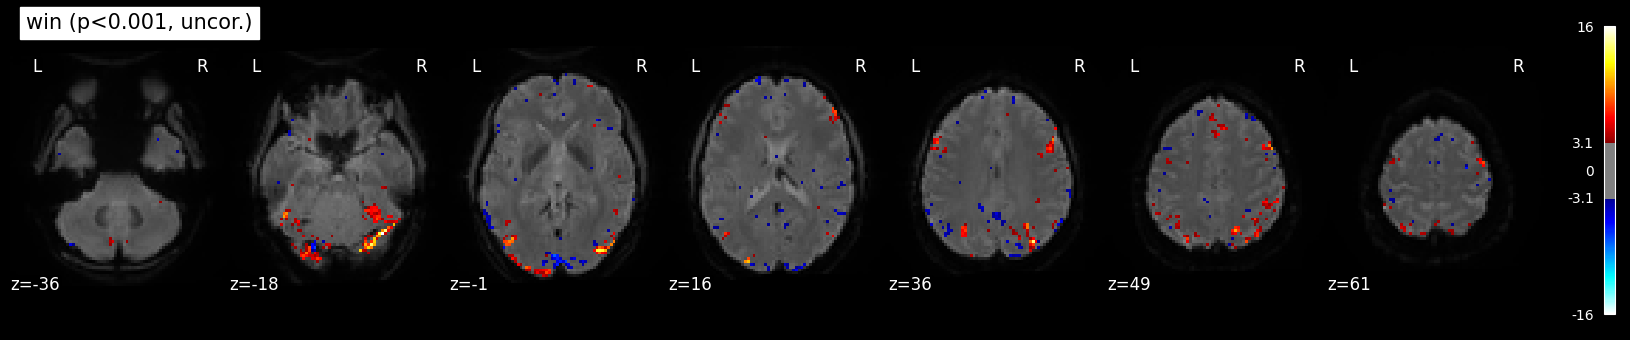

   Cluster ID          X           Y     Z  Peak Stat Cluster Size (mm3)
0           1  39.904001  -69.349999 -18.5  15.911452               1706
1          1a  29.800001  -79.454000 -18.5  13.493859                   
2          1b  19.696001  -84.506000 -18.5  10.857057                   
3           2  42.430001  -87.032000 -11.0  15.704394               2057
4          2a  37.378001  -84.506000  -1.0  12.926934                   
5          2b  29.800001  -84.506000   9.0  10.892667                   
6          2c  42.430001  -79.454000 -13.5   9.044816                   
7           3 -43.454000  -71.875999 -11.0  14.885345               3349
8          3a -28.297999  -81.980000  -6.0  10.890595                   
9          3b  -8.089999  -84.506000 -13.5  10.881939                   
10         3c -33.349999  -89.558000 -16.0   9.875598                   
11          4  32.326001  -76.927999  36.5  13.832124               2472
12         4a  32.326001  -69.349999  29.0  13.5177

/tmp/ipykernel_3260/3826969625.py:9: UserWarning: One contrast given, assuming it for all 4 runs
  z_map = model1.compute_contrast(contrast, output_type='z_score')


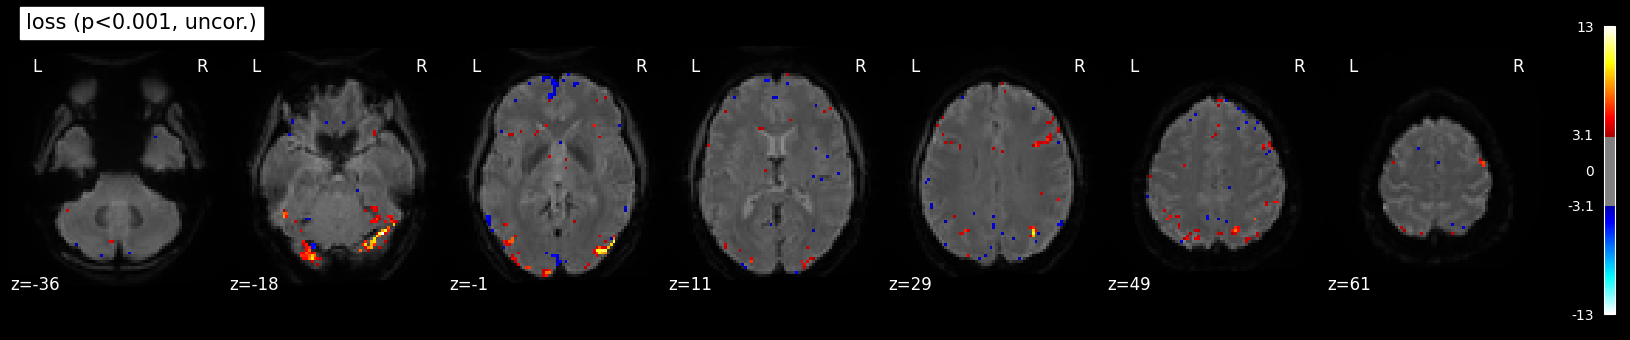

   Cluster ID          X           Y     Z  Peak Stat Cluster Size (mm3)
0           1  39.904001  -69.349999 -18.5  12.659105               1052
1          1a  24.748001  -79.454000 -16.0   9.928934                   
2          1b  32.326001  -74.401999 -18.5   8.895719                   
3           2  39.904001  -84.506000  -1.0  10.615082               2089
4          2a  29.800001  -92.084000  -6.0   7.963705                   
5          2b  29.800001  -84.506000   9.0   6.413411                   
6          2c  24.748001  -92.084000 -13.5   6.083942                   
7           3  50.008001  -76.927999  -1.0  10.029152                350
8           4 -13.141999 -104.714000   6.5   9.929222                494
9          4a  -8.089999 -104.714000  -1.0   6.731106                   
10          5  44.956001  -84.506000  -8.5   9.751306                350
11         5a  47.482001  -76.927999 -13.5   4.220838                   
12          6  32.326001  -76.927999  36.5   9.6887

/tmp/ipykernel_3260/3826969625.py:9: UserWarning: One contrast given, assuming it for all 4 runs
  z_map = model1.compute_contrast(contrast, output_type='z_score')


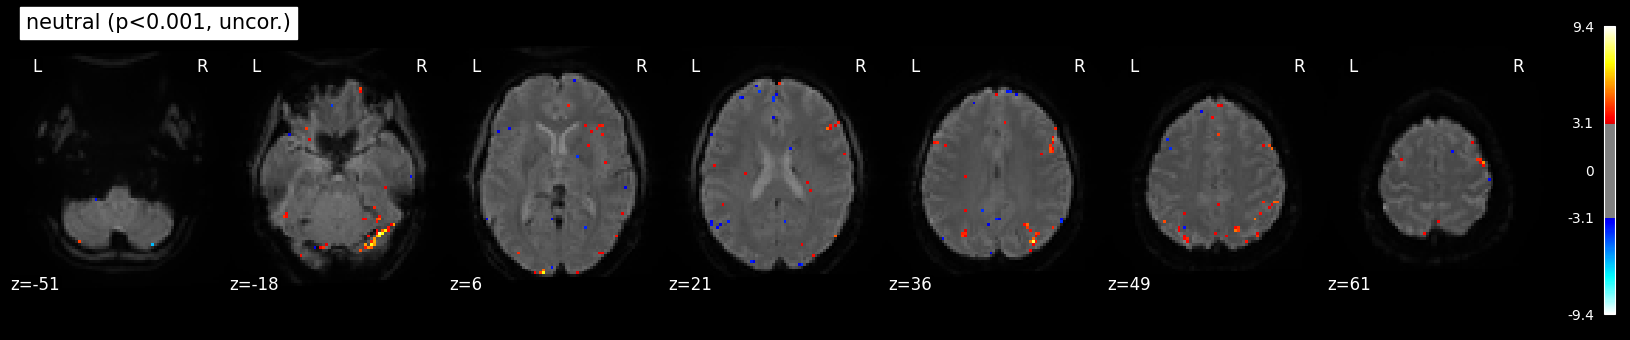

  Cluster ID          X          Y     Z  Peak Stat Cluster Size (mm3)
0          1  37.378001 -69.349999 -18.5   8.384907                414
1          2  32.326001 -76.927999  36.5   7.723275                909
2         2a  24.748001 -61.771999  39.0   6.621012                   
3         2b  34.852001 -69.349999  36.5   4.350367                   
4          3  44.956001  11.482001  31.5   7.166814                510
5         3a  34.852001   8.956001  29.0   4.891032                   
6          4  39.904001 -84.506000  -1.0   6.172285                510
7         4a  29.800001 -92.084000  -6.0   5.195332                   


/tmp/ipykernel_3260/3826969625.py:9: UserWarning: One contrast given, assuming it for all 4 runs
  z_map = model1.compute_contrast(contrast, output_type='z_score')


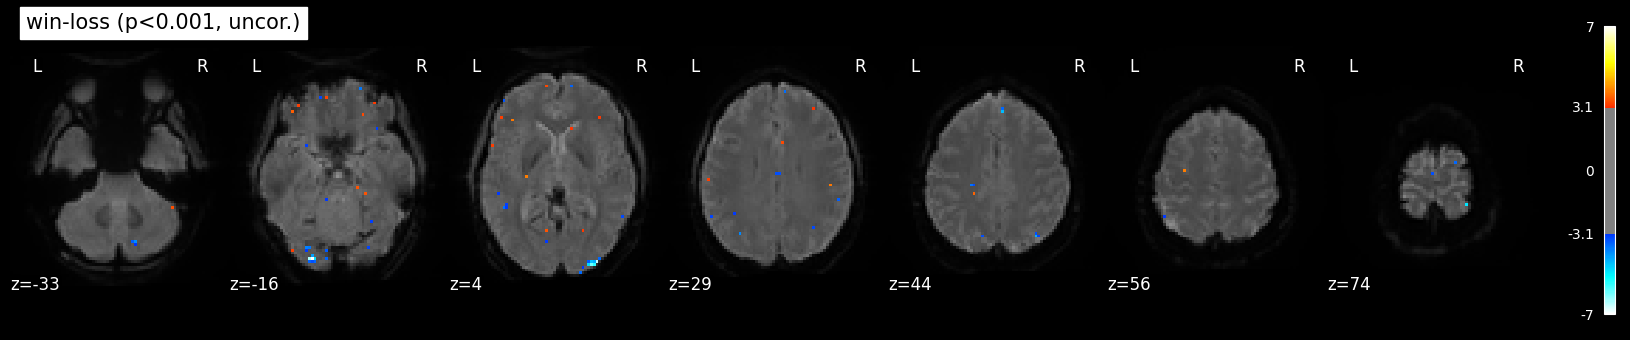

/tmp/ipykernel_3260/3826969625.py:19: UserWarning: Attention: No clusters with stat higher than 3.090232306167813
  table = get_clusters_table(z_map, stat_threshold=p001_unc,
/tmp/ipykernel_3260/3826969625.py:9: UserWarning: One contrast given, assuming it for all 4 runs
  z_map = model1.compute_contrast(contrast, output_type='z_score')


Empty DataFrame
Columns: [Cluster ID, X, Y, Z, Peak Stat, Cluster Size (mm3)]
Index: []


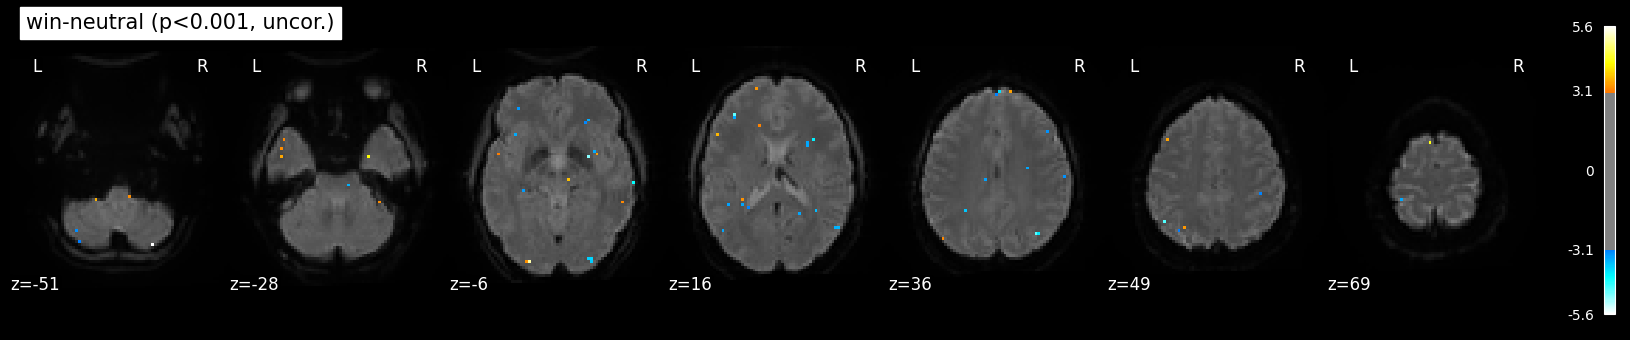

Empty DataFrame
Columns: [Cluster ID, X, Y, Z, Peak Stat, Cluster Size (mm3)]
Index: []
Finishing cell: 09:43:26


/tmp/ipykernel_3260/3826969625.py:19: UserWarning: Attention: No clusters with stat higher than 3.090232306167813
  table = get_clusters_table(z_map, stat_threshold=p001_unc,


In [20]:
# Make a mean image for display purposes
mean_img_ = mean_img(imgs1)

for contrast in contrasts:
    z_map = model1.compute_contrast(contrast, output_type = 'z_score')

    titlex=''.join([contrast, ' ', '(p<0.001, uncor.)'])
    plot_stat_map(z_map, bg_img = mean_img_, threshold = p001_unc,
              display_mode = 'z',  black_bg = True,
              title = titlex)
    plt.show()
    
    # Make a table of cluster coordinates.
    table = get_clusters_table(z_map, stat_threshold = p001_unc,
                           cluster_threshold = 20)
    print(table)
    
now = datetime.now()
print('Finishing cell:',now.strftime("%H:%M:%S"))

### Making an F contrast


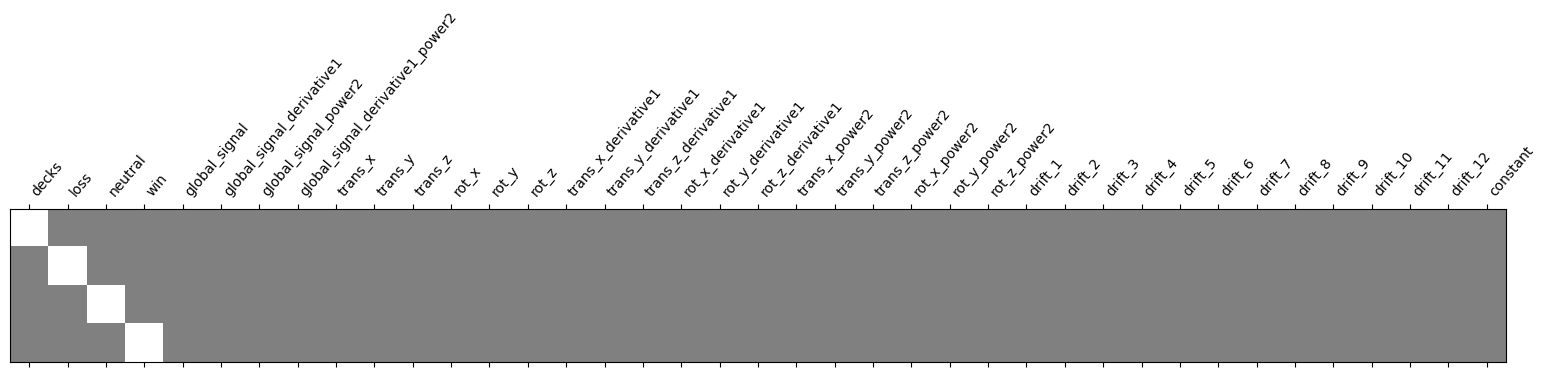

/tmp/ipykernel_3260/2797195158.py:11: UserWarning: One contrast given, assuming it for all 4 runs
  z_map = model1.compute_contrast(effects_of_interest,
/work/SofieNørboMosegaard#5741/AdvCogNeuro/virt_env/lib/python3.12/site-packages/nilearn/glm/contrasts.py:159: UserWarning: Running approximate fixed effects on F statistics.
  contrast = contrast_ if contrast is None else contrast + contrast_


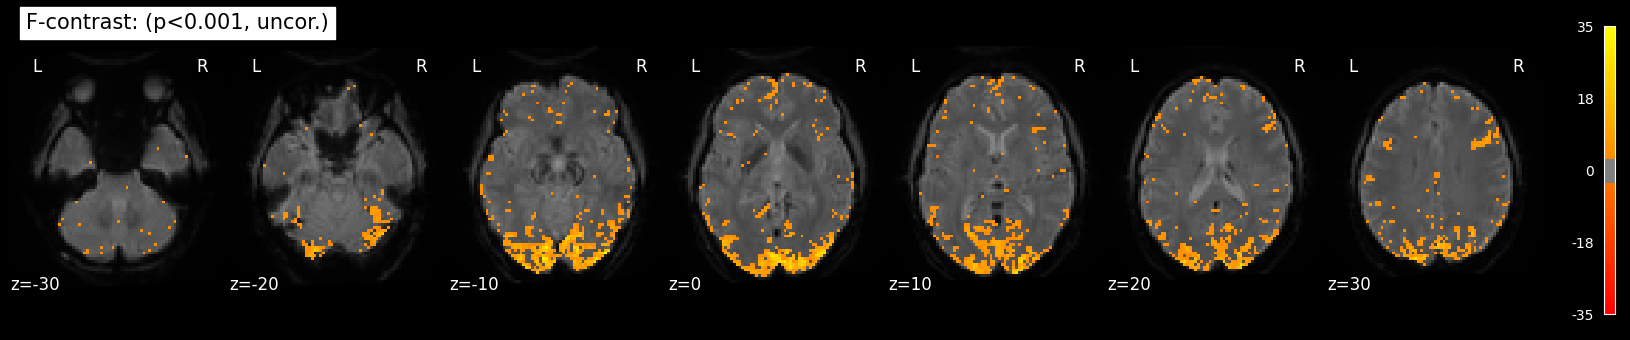

   Cluster ID          X          Y     Z  Peak Stat Cluster Size (mm3)
0           1   4.540001 -94.610000   1.5  35.437108              75371
1          1a  42.430001 -87.032000 -11.0  34.073422                   
2          1b -13.141999 -89.558000 -13.5  33.693258                   
3          1c  17.170001 -71.875999 -13.5  32.322503                   
4           2 -15.667999 -87.032000  41.5  13.841687               2488
..        ...        ...        ...   ...        ...                ...
56        24a -10.615999 -64.297999   4.0   3.206102                   
57         25  57.586001 -49.141999   4.0   5.496401                701
58        25a  62.638001 -54.193999  14.0   5.404894                   
59        25b  62.638001 -54.193999   4.0   5.005044                   
60        25c  57.586001 -51.667999  14.0   4.860860                   

[61 rows x 6 columns]


In [21]:
# create a contrast matrix for the F-contrast, spanning the two first columns in the design matrix
effects_of_interest = np.identity(design_matrix.shape[1])[[0,1,2,3],:]

# Let's see what it looks like
plot_contrast_matrix(effects_of_interest, design_matrix)
plt.show()

# Similar to above, we will compute the effect
z_map = model1.compute_contrast(effects_of_interest,
                                  output_type='z_score')

# And plot the results using an overlay
plot_stat_map(z_map, bg_img=mean_img_, threshold=p001_unc, cmap='autumn',
              display_mode='z',  black_bg=True,cut_coords=[-30,-20,-10,0,10,20,30],
              title='F-contrast: (p<0.001, uncor.)')
plt.show()
    
# Make a table of cluster coordinates.
table = get_clusters_table(z_map, stat_threshold=p001_unc,
                           cluster_threshold=20)
print(table)

### Analysing all single participants in one go and plotting them

In [120]:
# Remember to change this to your personal folder

res_dir='/work/SofieNørboMosegaard#5741/AdvCogNeuro/res_iowa2024_WIN_LOSS'

if os.path.isdir(res_dir) == False:
    print('Making results directory:', res_dir)
    os.mkdir(res_dir)
    n_res_files = len([name for name in os.listdir('.') if os.path.isfile(name)])
    print ('Number of files in results folder: ', n_res_files)

else:
    print('Results directory ', res_dir, 'already exists')
    #Count number of files in results directory
    wd=os.getcwd()
    os.chdir(res_dir)
    n_res_files = len([name for name in os.listdir('.') if os.path.isfile(name)])
    print ('Number of files in results folder: ', n_res_files)
    os.chdir(wd)

Results directory  /work/SofieNørboMosegaard#5741/AdvCogNeuro/res_iowa2024_WIN_LOSS already exists
Number of files in results folder:  8


In [121]:
now = datetime.now()
print('Starting cell:', now.strftime("%H:%M:%S"))

# Zip model and args
model_and_args = zip(models, models_run_imgs, models_events, models_confounds)

for m_idx, (model, imgs, events, confounds) in enumerate(model_and_args):
    print(f"Processing subject: {model.subject_label}")
    
    # File path where the model would be saved
    file = os.path.join(res_dir, f'iowa2024_WIN_LOSS_first_level_model_{model.subject_label}.pkl')

    # Check if the model has already been saved
    if os.path.exists(file):
        print(f"Skipping participant: {model.subject_label} (Already saved: {file})")
        continue  # Skip to the next iteration if the file exists

    # Fit the GLM for subjects not yet processed
    if m_idx + 1 > n_res_files:
        print(f"Fitting participant: {model.subject_label}, ({m_idx + 1}/{len(models)})")
    
        # Fit the model
        model.fit(imgs, events, confounds)

        # Print the column names in the design matrix for debugging (OBS sub 141 doesnt work?)
        print(f"Design matrix columns for {model.subject_label}: {model.design_matrices_[0].columns.tolist()}")

        # Check if 'win' and 'loss' are valid contrast terms
        if 'win' in model.design_matrices_[0].columns and 'loss' in model.design_matrices_[0].columns:
            try:
                # Explicitly check for multi-run data and compute contrast accordingly
                print(f"Computing contrast 'win - loss' for {model.subject_label}")
                
                # Compute contrast
                model.zmap = model.compute_contrast('win - loss', output_type = 'z_score')
                
                # Save fitted model
                print('Saving:', file)
                with open(file, 'wb') as f:
                    pickle.dump([model], f)

                now = datetime.now()
                print('Finished fitting:', model.subject_label, now.strftime("%H:%M:%S"))
            
            except ValueError as e:
                print(f"Error computing contrast for {model.subject_label}: {e}")
        
        else:
            print(f"Skipping participant: {model.subject_label} (No 'win' or 'loss' contrasts)")

now = datetime.now()
print('Finishing cell:', now.strftime("%H:%M:%S"))

Starting cell: 13:50:24
Processing subject: 0139
Skipping participant: 0139 (Already saved: /work/SofieNørboMosegaard#5741/AdvCogNeuro/res_iowa2024_WIN_LOSS/iowa2024_WIN_LOSS_first_level_model_0139.pkl)
Processing subject: 0136
Skipping participant: 0136 (Already saved: /work/SofieNørboMosegaard#5741/AdvCogNeuro/res_iowa2024_WIN_LOSS/iowa2024_WIN_LOSS_first_level_model_0136.pkl)
Processing subject: 0142
Skipping participant: 0142 (Already saved: /work/SofieNørboMosegaard#5741/AdvCogNeuro/res_iowa2024_WIN_LOSS/iowa2024_WIN_LOSS_first_level_model_0142.pkl)
Processing subject: 0140
Skipping participant: 0140 (Already saved: /work/SofieNørboMosegaard#5741/AdvCogNeuro/res_iowa2024_WIN_LOSS/iowa2024_WIN_LOSS_first_level_model_0140.pkl)
Processing subject: 0141
Processing subject: 0138
Skipping participant: 0138 (Already saved: /work/SofieNørboMosegaard#5741/AdvCogNeuro/res_iowa2024_WIN_LOSS/iowa2024_WIN_LOSS_first_level_model_0138.pkl)
Finishing cell: 13:50:24


## Saving results.

In [122]:
# Save the first level models

# Saving the objects:
f = open('/work/SofieNørboMosegaard#5741/AdvCogNeuro/res_iowa2024_WIN_LOSS/iowa2024_WIN_LOSS_first_level_model_ALL.pkl', 'wb')
pickle.dump([models, models_run_imgs, models_events, models_confounds], f)
f.close()

# Getting back the objects:
#f = open('store.pckl', 'rb')
#models, models_run_imgs, models_events, models_confounds = pickle.load(f)
#f.close()

now = datetime.now()
print('Finishing cell:',now.strftime("%H:%M:%S"))

Finishing cell: 13:50:42


In [126]:
res_dir='/work/SofieNørboMosegaard#5741/AdvCogNeuro/res_iowa2024_WIN_LOSS'

# Check if models are already loaded and if not --> load them
if 'models' not in locals():
    print('Loading saved first-level variables.')

    # Loading the data if it's not already loaded
    with open('/work/SofieNørboMosegaard#5741/AdvCogNeuro/res_iowa2024_WIN_LOSS/iowa2024_WIN_LOSS_first_level_model_ALL.pkl', 'rb') as f:
        models, models_run_imgs, models_events, models_confounds = pickle.load(f)

        
# Load individually fitted models
for m_idx, model in enumerate(models):
    print(f"Loading fitted model for participant: {models[m_idx].subject_label} ({m_idx + 1}/{len(models)})")
    file = os.path.join(res_dir, f'iowa2024_WIN_LOSS_first_level_model_{model.subject_label}.pkl')

    # Check if the file exists
    if os.path.exists(file):
        with open(file, 'rb') as f:
            loaded_model = pickle.load(f)
        
        # Verify if the subject labels match
        if models[m_idx].subject_label == loaded_model[0].subject_label:
            models[m_idx] = loaded_model[0]
            print(f"Successfully loaded model for participant: {model.subject_label}")
        else:
            print(f"Subject mismatch for {model.subject_label}")
    else:
        # File not found, skip this participant
        print(f"Skipping participant {model.subject_label} (No saved model file found)")

print("All available models loaded.")


Loading fitted model for participant: 0139 (1/6)
Successfully loaded model for participant: 0139
Loading fitted model for participant: 0136 (2/6)
Successfully loaded model for participant: 0136
Loading fitted model for participant: 0142 (3/6)
Successfully loaded model for participant: 0142
Loading fitted model for participant: 0140 (4/6)
Successfully loaded model for participant: 0140
Loading fitted model for participant: 0141 (5/6)
Skipping participant 0141 (No saved model file found)
Loading fitted model for participant: 0138 (6/6)
Successfully loaded model for participant: 0138
All available models loaded.


In [ ]:
p001_unc = norm.isf(0.001)
fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize = (24, 20)) 

for m_idx, model in enumerate(models):

    #Plot each thresholded analysis
    plotting.plot_glass_brain(model.zmap, cmap = 'jet', colorbar = True, threshold = p001_unc,
                              title = ('sub-' + model.subject_label),
                              axes = axes[int(m_idx / 3), int(m_idx % 3)],
                              plot_abs = False, display_mode = 'x')

## Second level (group) model estimation


In [ ]:
# First, let's ensure we load any previously saved models if not already in memory
res_dir = '/work/SofieNørboMosegaard#5741/AdvCogNeuro/res_iowa2024_WIN_LOSS'

if 'models' not in locals():
    print('Loading saved first-level models.')
    with open(os.path.join(res_dir, 'iowa2024_WIN_LOSS_first_level_model_ALL.pkl'), 'rb') as f:
        models, models_run_imgs, models_events, models_confounds = pickle.load(f)

# Now let's make sure we fit only the models that need to be fit
fitted_models = []

for m_idx, model in enumerate(models):
    try:
        # Check if the model has already been fit
        if hasattr(model, 'design_matrices_') and model.design_matrices_ is not None:
            print(f"Model {model.subject_label} has already been fit. Skipping.")
            fitted_models.append(model)
            continue
        
        # Fit the model if not already fit
        print(f"Fitting model for participant: {model.subject_label}")
        model.fit(models_run_imgs[m_idx], models_events[m_idx], models_confounds[m_idx])
        fitted_models.append(model)
    
    except Exception as e:
        print(f"Error fitting model for participant {model.subject_label}: {e}")
        # Optionally skip this participant or continue fitting others
        continue

# After the loop, fitted_models should contain only the fit models
print(f"Successfully fitted {len(fitted_models)} out of {len(models)} models.")

# Now let's proceed with the second-level analysis on the fitted models
second_level_input = fitted_models  # Only pass the fitted models

# Add smoothing and fit the second-level model
second_level_model = SecondLevelModel(smoothing_fwhm=8.0)
second_level_model = second_level_model.fit(second_level_input)

print("Second-level model successfully fit!")


In [133]:
# We will simply add the models estimated above to the second level
second_level_input = [model for model in models if model.subject_label != '0141']
#second_level_input = models

# Adding the smoothing parameter
second_level_model = SecondLevelModel(smoothing_fwhm=8.0)

# Fit the second-level model with the selected models (excluding 0141)
second_level_model = second_level_model.fit(second_level_input)

print(second_level_model)

/work/SofieNørboMosegaard#5741/AdvCogNeuro/virt_env/lib/python3.12/site-packages/nilearn/glm/second_level/second_level.py:361: UserWarning: One contrast given, assuming it for all 4 runs
  sample_map = sample_model.compute_contrast(


SecondLevelModel(smoothing_fwhm=8.0)


In [134]:
# NB, variable names used in contrasts have to be the same as those in events file.
zmap_g = second_level_model.compute_contrast(
    first_level_contrast = 'win-loss')

/work/SofieNørboMosegaard#5741/AdvCogNeuro/virt_env/lib/python3.12/site-packages/nilearn/glm/second_level/second_level.py:307: UserWarning: One contrast given, assuming it for all 4 runs
  effect_map = model.compute_contrast(
/work/SofieNørboMosegaard#5741/AdvCogNeuro/virt_env/lib/python3.12/site-packages/nilearn/glm/second_level/second_level.py:307: UserWarning: One contrast given, assuming it for all 4 runs
  effect_map = model.compute_contrast(
/work/SofieNørboMosegaard#5741/AdvCogNeuro/virt_env/lib/python3.12/site-packages/nilearn/glm/second_level/second_level.py:307: UserWarning: One contrast given, assuming it for all 4 runs
  effect_map = model.compute_contrast(
/work/SofieNørboMosegaard#5741/AdvCogNeuro/virt_env/lib/python3.12/site-packages/nilearn/glm/second_level/second_level.py:307: UserWarning: One contrast given, assuming it for all 4 runs
  effect_map = model.compute_contrast(
/work/SofieNørboMosegaard#5741/AdvCogNeuro/virt_env/lib/python3.12/site-packages/nilearn/glm/sec

In [135]:
# Initialize list for the the contrast maps (z-maps) from the first-level models
contrast_maps = []

for model in models:
    try:
        # Make sure the 'win - loss' contrast is available
        if 'win' in model.design_matrices_[0].columns and 'loss' in model.design_matrices_[0].columns:
            zmap = model.compute_contrast('win - loss', output_type = 'z_score')
            contrast_maps.append(zmap)
        else:
            print(f"Skipping participant {model.subject_label}: No 'win' or 'loss' contrast available")
    
    except Exception as e:
        print(f"Error processing participant {model.subject_label}: {e}")

# Create design matrix for second-level model (e.g., a simple one-sample t-test)
# This assumes that you're running a one-sample t-test across the group of subjects
n_subjects = len(contrast_maps)
design_matrix = pd.DataFrame([1] * n_subjects, columns=['intercept'])

# Initialize and fit the second-level model + adding the smoothing parameter
second_level_model = SecondLevelModel(smoothing_fwhm = 8.0)
second_level_model = second_level_model.fit(contrast_maps, design_matrix = design_matrix)

# Compute the second-level contrast (e.g., one-sample t-test across subjects)
zmap_g = second_level_model.compute_contrast(output_type = 'z_score')

# Print the resulting second-level model
print(second_level_model)

/tmp/ipykernel_8431/3608644129.py:11: UserWarning: One contrast given, assuming it for all 4 runs
  zmap = model.compute_contrast('win - loss', output_type = 'z_score')
/tmp/ipykernel_8431/3608644129.py:11: UserWarning: One contrast given, assuming it for all 4 runs
  zmap = model.compute_contrast('win - loss', output_type = 'z_score')
/tmp/ipykernel_8431/3608644129.py:11: UserWarning: One contrast given, assuming it for all 4 runs
  zmap = model.compute_contrast('win - loss', output_type = 'z_score')
/tmp/ipykernel_8431/3608644129.py:11: UserWarning: One contrast given, assuming it for all 4 runs
  zmap = model.compute_contrast('win - loss', output_type = 'z_score')


Error processing participant 0141: 'FirstLevelModel' object has no attribute 'design_matrices_'


/tmp/ipykernel_8431/3608644129.py:11: UserWarning: One contrast given, assuming it for all 4 runs
  zmap = model.compute_contrast('win - loss', output_type = 'z_score')


SecondLevelModel(smoothing_fwhm=8.0)


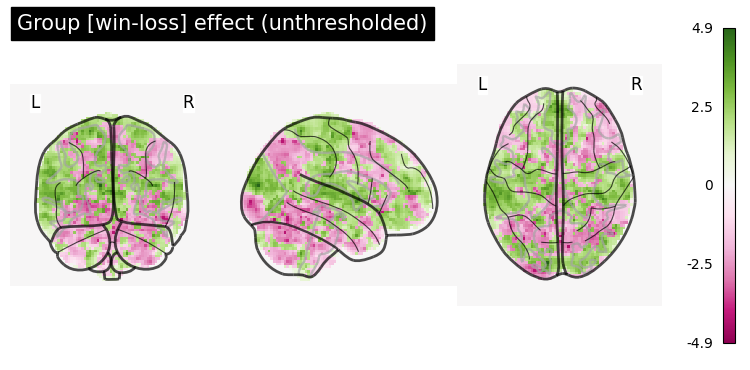

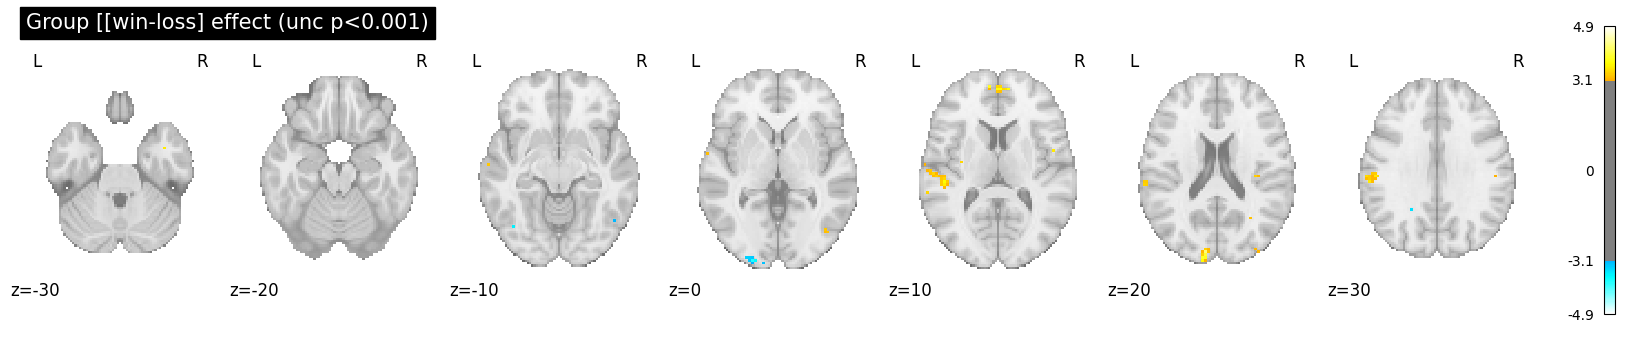

In [136]:
plotting.plot_glass_brain(zmap_g, cmap = 'PiYG',colorbar = True, threshold = None,
                          title = 'Group [win-loss] effect (unthresholded)',
                          plot_abs = False)
plt.show()

plot_stat_map(zmap_g, cmap = 'cold_hot', threshold = p001_unc, cut_coords = [-30,-20,-10,0,10,20,30],
              display_mode = 'z',  black_bg = False,
              title = 'Group [[win-loss] effect (unc p<0.001)')
plt.show()

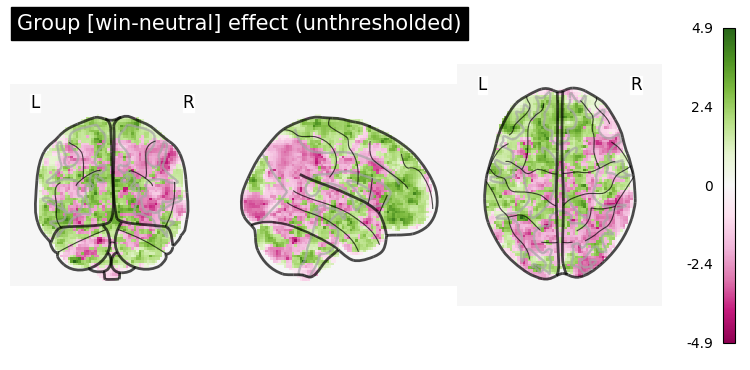

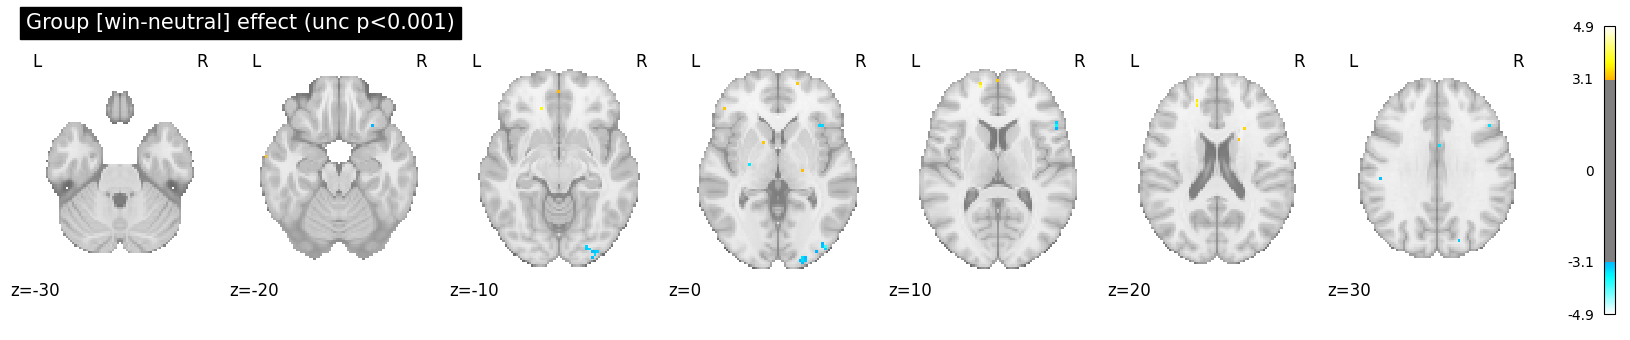

In [53]:
plotting.plot_glass_brain(zmap_g, cmap = 'PiYG',colorbar = True, threshold = None,
                          title = 'Group [win-neutral] effect (unthresholded)',
                          plot_abs = False)
plt.show()

plot_stat_map(zmap_g, cmap = 'cold_hot', threshold = p001_unc, cut_coords = [-30,-20,-10,0,10,20,30],
              display_mode = 'z',  black_bg = False,
              title = 'Group [win-neutral] effect (unc p<0.001)')
plt.show()

/work/SofieNørboMosegaard#5741/AdvCogNeuro/virt_env/lib/python3.12/site-packages/nilearn/glm/thresholding.py:297: UserWarning: The given float value must not exceed 5.0102593811486695. But, you have given threshold=5.054355726831918.
  stat_img = threshold_img(


The p<.05 FWER-corrected threshold is 5.05


/work/SofieNørboMosegaard#5741/AdvCogNeuro/virt_env/lib/python3.12/site-packages/nilearn/plotting/displays/_slicers.py:308: UserWarning: empty mask
  ims = self._map_show(img, type="imshow", threshold=threshold, **kwargs)


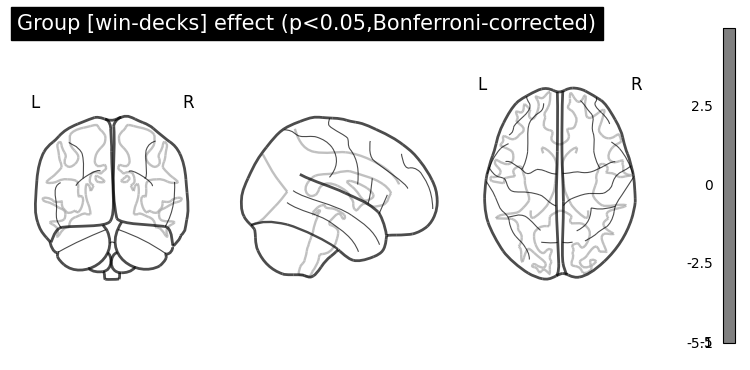

Empty DataFrame
Columns: [Cluster ID, X, Y, Z, Peak Stat, Cluster Size (mm3)]
Index: []


/work/SofieNørboMosegaard#5741/AdvCogNeuro/virt_env/lib/python3.12/site-packages/nilearn/reporting/get_clusters_table.py:302: UserWarning: The given float value must not exceed 5.0102593811486695. But, you have given threshold=5.054355726831918.
  stat_img = threshold_img(
/tmp/ipykernel_8431/796118871.py:13: UserWarning: Attention: No clusters with stat higher than 5.054355726831918
  table = get_clusters_table(zmap_g, stat_threshold=threshold)


In [72]:
thresholded_map, threshold = threshold_stats_img(
    zmap_g, alpha = 0.05, height_control = 'bonferroni')
print('The p<.05 FWER-corrected threshold is %.3g' % threshold)

plotting.plot_glass_brain(zmap_g, cmap = 'PiYG', colorbar = True, threshold = threshold,
                          title = 'Group [win-decks] effect (p<0.05,Bonferroni-corrected)',
                          plot_abs = False)
plt.show()

# Make a table of cluster coordinates.
table = get_clusters_table(zmap_g, stat_threshold=threshold)
print(table)

## Classification

In [ ]:
with open('/work/SofieNørboMosegaard#5741/AdvCogNeuro/res_iowa2024_WIN_LOSS/iowa_first_level_models_all_trials.pkl', 'rb') as f:
    model1, lsa_dm_all, conditions_label, b_maps = pickle.load(f)

In [ ]:
with open('/work/SofieNørboMosegaard#5741/AdvCogNeuro/res_iowa2024_WIN_LOSS/iowa2024_WIN_LOSS_first_level_model_ALL.pkl', 'rb') as f:
    models, models_run_imgs, models_events, models_confounds = pickle.load(f)

In [ ]:
b_maps_conc = concat_imgs(b_maps)

# Prepare for classification
print(f'Number of trials: {len(conditions_label)}') # Number of trials: 1920

# Prepare the data for classification
X = np.array([img.get_fdata().flatten() for img in b_maps])
y = np.array(conditions_label)

In [ ]:
# Identify win and loss trials based on the condition label
idx_win = [int(i) for i in range(len(conditions_label)) if 'win_' in conditions_label[i]]
idx_loss = [int(i) for i in range(len(conditions_label)) if 'loss_' in conditions_label[i]]

# Relabel the conditions as 'win' or 'loss'
for i in range(len(conditions_label)):
    if i in idx_win:
        conditions_label[i] = 'win'
    if i in idx_loss:
        conditions_label[i] = 'loss'

print(conditions_label)

In [ ]:
# Combine indices for win and loss trials
idx = np.concatenate((idx_win, idx_loss))

# Select the relevant trials (win and loss) from the conditions_label
conditions = np.array(conditions_label)[idx]
print(conditions)  # This should now print only 'win' and 'loss' labels

# Select the corresponding beta maps for these trials
b_maps_img = index_img(b_maps_conc, idx)
print(b_maps_img.shape)  # Check the shape of the filtered beta maps

In [ ]:
# under sample 

# Separate the indices for the "win" and "loss" conditions
idx_win = np.where(conditions == 'win')[0]
idx_loss = np.where(conditions == 'loss')[0]

# Randomly select an equal number of "win" samples as there are "loss" samples
np.random.seed(123) 
undersampled_idx_win = np.random.choice(idx_win, size = len(idx_loss), replace = False)

# Combine the undersampled "win" indices with the "loss" indices
undersampled_idx = np.concatenate((undersampled_idx_win, idx_loss))

# Shuffle the undersampled indices to avoid any ordering bias
np.random.shuffle(undersampled_idx)

# Apply the undersampling to conditions and beta maps
undersampled_conditions = conditions[undersampled_idx]
undersampled_b_maps_img = index_img(b_maps_conc, undersampled_idx)

print("Undersampled class distribution:", Counter(undersampled_conditions))
# Undersampled class distribution: Counter({'loss': 104, 'win': 104})

In [ ]:
# Prepare the data for classification
X = np.array([img.get_fdata().flatten() for img in iter_img(b_maps_img)])  # Features (beta maps)
y = np.array(conditions)  # Labels ('win' or 'loss')

print(X)
print(y)

In [ ]:
class_counts = Counter(conditions)
print(class_counts)

#Counter({'win': 687, 'loss': 104})

In [ ]:
# Random train-test split (80% training, 20% testing)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

# Print split details to check everything is in order
print(f'Training set size: {len(X_train)}, Testing set size: {len(X_test)}')

#Training set size: 166, Testing set size: 42

In [ ]:
# Train a Naive Bayes classifier
nb_classifier = GaussianNB()
nb_classifier.fit(X_train, y_train)

In [ ]:
# Make predictions
y_pred = nb_classifier.predict(X_test)

In [ ]:
# Evaluate the performance
print(classification_report(y_test, y_pred))

# Counter({'loss': 104, 'win': 104})

In [ ]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
#plt.savefig('/work/SofieNørboMosegaard#5741/AdvCogNeuro/confusion_matrix.png')
plt.show()
plt.close()


In [ ]:
# Set up parameters for permutation testing
n_permutations = 100 
n_classes = 2

clf = GaussianNB()
real_accuracy = accuracy_score(y_test, clf.fit(X_train, y_train).predict(X_test)) 
permutation_accuracies = np.zeros(n_permutations)

# Run permutation testing
for i in range(n_permutations):
    np.random.seed(i)  # Ensure reproducibility
    y_train_permuted = np.random.permutation(y_train)  # Shuffle the training labels
    
    # Train classifier with permuted labels and calculate accuracy
    clf.fit(X_train, y_train_permuted)
    y_pred = clf.predict(X_test)
    permutation_accuracies[i] = accuracy_score(y_test, y_pred)


# Calculate p-value
p_value = np.mean(permutation_accuracies >= real_accuracy)

print(f'Real Accuracy: {real_accuracy:.4f}')
print(f'Permutation Test p-value: {p_value:.4f}')

# plot
plt.figure(figsize=(8, 6))
plt.hist(permutation_accuracies, 20, label='Permutation scores', edgecolor='black')

ylim = plt.ylim()
plt.plot(2 * [real_accuracy], ylim, '--g', linewidth=3, label=f'Classification Score (p-value {p_value:.4f})')
plt.plot(2 * [1. / n_classes], ylim, '--k', linewidth=3, label='Chance level (50%)')

plt.title('Permutation Test')
plt.xlabel('Score')
plt.ylim(ylim)
plt.legend()

plt.savefig('/work/SofieNørboMosegaard#5741/AdvCogNeuro/permutation_test.png')
plt.show()
